In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from bqplot import pyplot as bplt
from bqplot import (
    LogScale, LinearScale, OrdinalColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip
)

import ipywidgets as ipyw
import seaborn as sns
import pandas as pd
import SFG2D
import gui

from IPython.display import display
from watchdog.observers import Observer

# Set plot layout
#plt.style.use('seaborn-notebook')
#sns.set_style("white")
#sns.set_style("ticks")
#sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Setup Data and Widget class
ppdData = gui.PumpProbeDashboardData('/home/malte/MeasurmentData/2016/08/01/')
ppWidget = gui.PumpProbeWidget(ppdData)
ppWidget.linkTraitlets()
#ppWidget.setupObservers(ppdData)

# Setup file observer
ffolder_observer = Observer()
event_handler = gui.MyHandler()
event_handler.ppdData = ppdData
event_handler.ppWidget = ppWidget
ffolder_observer.schedule(event_handler, ppdData.ffolder, recursive=False)
ffolder_observer.start()

## IR Profile

In [2]:
class w_ir():
    
    def get(fpath, fbase):
        ppdData.ir = fpath
        ppdData.ir.base = SFG2D.io.veronica.read_auto(ppdData.ffolder + fbase).med

        # Because update_sub_baseline is only called on change
        if ppWidget.ir_sub_base.value:
            ppdData.ir.sub_base(inplace=True)

    def update(new):
        ppdData.ir = ppWidget.ir_fpath.value
        ppdData.ir.base = SFG2D.io.veronica.read_auto(ppdData.ffolder + ppWidget.ir_fbase.value).med

        if ppWidget.ir_sub_base.value:
            ppdData.ir.sub_base(inplace=True)
            
        ppdData.ir.spec = ppWidget.ir_spec.value

    def fig_init(param_dict={}):
        D = ppdData.ir
        bplt.plot(D.med.index, D.med.transpose(), **param_dict)

    def fig_update(new):
        ir_fig.marks[0].x = ppdData.ir.df.index
        ir_fig.marks[0].y = ppdData.ir.spec.transpose()

    def sub_baseline_update(new):
        if ppWidget.ir_sub_base.value:
            ppdData.ir.sub_base(inplace=True)
        else: 
            ppdData.ir.add_base(inplace=True)
    
    def update_spec(new):
        ppdData.ir.spec = ppWidget.ir_spec.value 

w_ir.get(ppWidget.ir_fpath.value, ppWidget.ir_fbase.value)

ir_fig = bplt.figure()
w_ir.fig_init()

ppWidget.ir_fpath.observe(w_ir.update, 'value')
ppWidget.ir_fpath.observe(w_ir.fig_update, 'value')

ppWidget.ir_fbase.observe(w_ir.update, 'value')
ppWidget.ir_fbase.observe(w_ir.fig_update, 'value')

ppWidget.ir_sub_base.observe(w_ir.sub_baseline_update, 'value')
ppWidget.ir_sub_base.observe(w_ir.fig_update, 'value')

ppWidget.ir_spec.observe(w_ir.update_spec, 'value')
ppWidget.ir_spec.observe(w_ir.fig_update, 'value')

display(ppWidget.ir_fpath, ppWidget.ir_fbase, ppWidget.ir_sub_base, ppWidget.ir_spec)
bplt.show()

/home/malte/Analysis/SFG2D/io/veronica.py:261: UserWarning: cant determine spectrum type of data by filename.Trying to determine datatype from content.This is much slower
  warnings.warn('cant determine spectrum type of data by filename.'


## Pump Profile

In [4]:
ppdData.ts0

In [3]:
class w_pump():
    def get(fpath):
        ppdData.pump = fpath
        if isinstance(ppdData.pump.pp_delays, pd.indexes.numeric.Int64Index):
            ppWidget.pump_ppdelay.options = list(ppdData.pump.pp_delays)
        ppdData.pump.spec = ppWidget.pump_spec.value
            
    def update(new):
        ppdData.pump = ppWidget.pump_fpath.value
        if isinstance(ppdData.pump.pp_delays, pd.indexes.numeric.Int64Index):
            ppWidget.pump_ppdelay.options = list(ppdData.pump.pp_delays)
            # guarantee pump_delay slider has a valid value
            if ppWidget.pump_ppdelay.value in ppdData.pump.pp_delays:
                ppdData.pump.ppdelay_current = ppWidget.pump_ppdelay.value
        else:
            ppWidget.pump_ppdelay.options = [0]
            ppWidget.pump_ppdelay.value = 0
        #ppdData.pump.base = SFG2D.io.veronica.read_auto(ppdData.ffolder + ppWidget.pump_fbase.value).med

        #if ppWidget.pu.value:
        #    ppdData.pump.sub_base(inplace=True)
            
        ppdData.pump.spec = ppWidget.pump_spec.value
     
    def fig_init(param_dict={}):
        D = ppdData.pump.current
        bplt.plot(D.index, D.transpose(), **param_dict)

    def fig_update(new):
        pump_fig.marks[0].x = ppdData.pump.current.index
        pump_fig.marks[0].y = ppdData.pump.current.transpose()

    def sub_baseline_update(new):
        raise NotImplementedError
    
    def update_spec(new):
        ppdData.pump.spec = ppWidget.pump_spec.value
        
    def update_ppdelay(new):
        ppdData.pump.ppdelay_current = ppWidget.pump_ppdelay.value
        
w_pump.get(ppWidget.pump_fpath.value)

pump_fig = bplt.figure()
w_pump.fig_init()

ppWidget.pump_fpath.observe(w_pump.update, 'value')
ppWidget.pump_fpath.observe(w_pump.fig_update, 'value')

#ppWidget.pump_fbase.observe(w_pump.update, 'value')
#ppWidget.pump_fbase.observe(w_pump.fig_update, 'value')

#ppWidget.pump_sub_base.observe(w_pump.sub_baseline_update, 'value')
#ppWidget.pump_sub_base.observe(w_pump.fig_update, 'value')
ppWidget.pump_ppdelay.observe(w_pump.update_ppdelay, 'value')
ppWidget.pump_ppdelay.observe(w_pump.fig_update, 'value')

ppWidget.pump_spec.observe(w_pump.update_spec, 'value')
ppWidget.pump_spec.observe(w_pump.fig_update, 'value')

display(ppWidget.pump_fpath, ppWidget.pump_spec, ppWidget.pump_ppdelay)
bplt.show()

/home/malte/Analysis/SFG2D/io/veronica.py:261: UserWarning: cant determine spectrum type of data by filename.Trying to determine datatype from content.This is much slower
  warnings.warn('cant determine spectrum type of data by filename.'


# Pump-Probe Data

## Baseline for Pump-Probe Data

In [3]:
class w_base():
    def get(fbase):
        ppdData.base = fbase
    
    def update(new):
        ppdData.base = ppWidget.fbase.value
        
    def fig_init(param_dict={}):
        D = ppdData.base.med
        bplt.plot(D.index, D.transpose(), **param_dict)
        
    def fig_update(new):
        base_fig.marks[0].x = ppdData.base.med.index
        base_fig.marks[0].y = ppdData.base.med.transpose()

def set_base(fbase):
    ppdData.base.med.plot()
    plt.title("Baseline")
    plt.draw()
    
w_base.get(ppWidget.fbase.value)
base_fig = bplt.figure()
w_base.fig_init()
ppWidget.fbase.observe(w_base.update, 'value')
ppWidget.fbase.observe(w_base.fig_update, 'value')
#w_base = ipyw.interactive(set_base, fbase = ppWidget.fbase)
display(ppWidget.fbase)
bplt.show()

/home/malte/Analysis/SFG2D/io/veronica.py:261: UserWarning: cant determine spectrum type of data by filename.Trying to determine datatype from content.This is much slower
  warnings.warn('cant determine spectrum type of data by filename.'


In [11]:
D = ppdData.ts0.med.sum(level="pp_delay")
D

,spec_0,spec_1,spec_2
pp_delay,,,
-1000,497657.0,498757.0,455692.0
-500,496512.0,497219.5,453919.0
-400,495918.5,496594.5,453166.5
-300,495747.0,496457.5,453135.5
-200,495957.5,496128.0,453381.5
-150,496745.0,496790.5,454133.0
-100,496800.0,496429.0,453596.0
-50,497203.0,496486.5,453626.0
0,497650.5,496817.5,453678.5


In [ ]:
ppWidget.t

In [17]:
D[ppWidget.ts0_pumped.value]

pp_delay
-1000     487808.0
-500      493595.0
-400      489165.0
-300      487570.0
-200      489679.0
-150      492246.0
-100      492688.0
-50       491731.0
 0        496019.0
 50       491017.0
 100      493612.0
 150      496514.0
 200      496798.0
 250      497858.0
 300      493508.0
 400      496130.0
 500      496865.0
 700      498343.0
 900      494134.0
 1200     493460.0
 2000     497666.0
 3000     499666.0
 5000     501298.0
 8000     499756.0
 20000    507911.0
Name: spec_0, dtype: float64

In [40]:
import pandas as pd
D = ppdData.ts0.df.sum(level="pp_delay")
#bplt.figure()
#bplt.plot(D.index, D[ppWidget.ts0_pumped.value])
D.iloc[:,0]#.append(D, ignore_index=True)

pp_delay
-1000     483301.0
-500      485289.0
-400      490958.0
-300      483517.0
-200      485762.0
-150      485160.0
-100      491897.0
-50       489759.0
 0        486071.0
 50       485706.0
 100      486880.0
 150      494862.0
 200      498053.0
 250      493505.0
 300      493875.0
 400      491699.0
 500      499040.0
 700      496492.0
 900      497558.0
 1200     502143.0
 2000     500106.0
 3000     503273.0
 5000     492988.0
 8000     493924.0
 20000    498555.0
Name: spec_0, dtype: float64

In [66]:
D["spec_0"].as_matrix().transpose()

array([[ 483301.,  485289.,  490958.,  483517.,  485762.,  485160.,
         491897.,  489759.,  486071.,  485706.,  486880.,  494862.,
         498053.,  493505.,  493875.,  491699.,  499040.,  496492.,
         497558.,  502143.,  500106.,  503273.,  492988.,  493924.,
         498555.],
       [ 498753.,  496089.,  498477.,  495117.,  496048.,  494152.,
         494727.,  500416.,  495055.,  499983.,  496824.,  496005.,
         497223.,  499780.,  497557.,  497123.,  499864.,  503814.,
         499951.,  503539.,  499329.,  507448.,  498894.,  499946.,
         500118.],
       [ 499104.,  498665.,  499042.,  499533.,  498590.,  500519.,
         500313.,  497931.,  501176.,  501253.,  500354.,  501528.,
         502457.,  503734.,  509274.,  503214.,  502255.,  501945.,
         501358.,  503292.,  504613.,  506155.,  503415.,  508533.,
         501796.],
       [ 511342.,  505343.,  508509.,  501835.,  501950.,  507250.,
         508483.,  502800.,  504960.,  509095.,  506272.,  

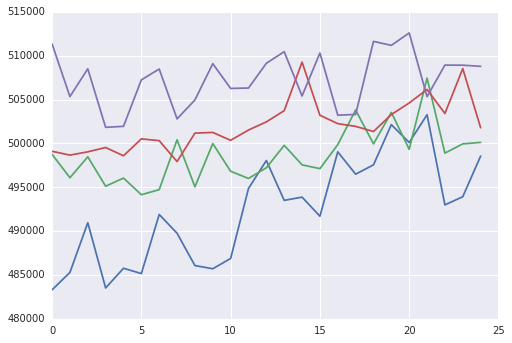

In [113]:
m = D["spec_0"].as_matrix()
mf = m.flatten()
plt.plot(D["spec_0"].as_matrix())

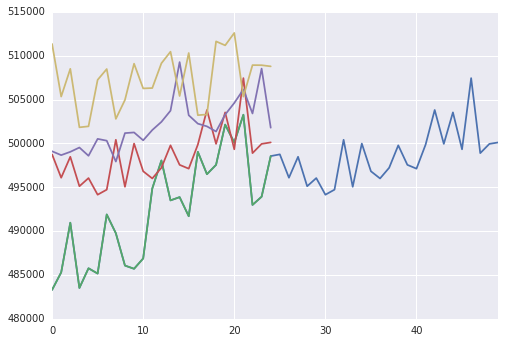

In [106]:
DD = pd.concat([D["spec_0"].iloc[:,0], D["spec_0"].iloc[:,1]], ignore_index=True)#.plot()
DD.plot()
m = D["spec_0"].as_matrix()
#mr = m.reshape(100)
plt.plot(m)
#D.re

In [105]:
mr

array([ 483301.,  498753.,  499104.,  511342.,  485289.,  496089.,
        498665.,  505343.,  490958.,  498477.,  499042.,  508509.,
        483517.,  495117.,  499533.,  501835.,  485762.,  496048.,
        498590.,  501950.,  485160.,  494152.,  500519.,  507250.,
        491897.,  494727.,  500313.,  508483.,  489759.,  500416.,
        497931.,  502800.,  486071.,  495055.,  501176.,  504960.,
        485706.,  499983.,  501253.,  509095.,  486880.,  496824.,
        500354.,  506272.,  494862.,  496005.,  501528.,  506316.,
        498053.,  497223.,  502457.,  509138.,  493505.,  499780.,
        503734.,  510463.,  493875.,  497557.,  509274.,  505411.,
        491699.,  497123.,  503214.,  510312.,  499040.,  499864.,
        502255.,  503221.,  496492.,  503814.,  501945.,  503305.,
        497558.,  499951.,  501358.,  511637.,  502143.,  503539.,
        503292.,  511184.,  500106.,  499329.,  504613.,  512601.,
        503273.,  507448.,  506155.,  505337.,  492988.,  4988

In [9]:
class w_pump_probe():
    def get(fpath):
        ppdData.ts0 = SFG2D.io.veronica.read_auto(ppdData.ffolder + fpath)
        if ppWidget.ts0_sub_base.value:
            ppdData.ts0.base = ppdData.base.med
            ppdData.ts0.sub_base(inplace=True)
        if ppWidget.ir_spec.value is "All":
            ppdData.ts0.norm = ppdData.ir.med
        else:
            ppdData.ts0.norm = ppdData.ir.med[ppWidget.ir_spec.value]
        ppdData.ts0u = ppdData.ts0.__deepcopy__()
        
        if ppWidget.ts0_normalize.value:
            ppdData.ts0.normalize(inplace=True)
        ppWidget.ts0_ppdelay.options = list(ppdData.ts0.pp_delays)
        
        if ppWidget.ts0_ppdelay.value not in list(ppdData.ts0.pp_delays):
            ppWidget.ts0_ppdelay.value = ppWidget.ts0_ppdelay.options[0]
        
    def update(new):
        w_pump_probe.get(ppWidget.ts0_fpath.value)
        
    def pump_update(new):
        ppdData.ts0.pumped = ppWidget.ts0_pumped.value
        ppdData.ts0u.pumped = ppWidget.ts0_pumped.value
    
    def probe_update(new):
        ppdData.ts0u.probed = ppWidget.ts0_probed.value
        ppdData.ts0.probed = ppWidget.ts0_probed.value  
        
    def fig_init():
        #bplt.figure(pump_probe_fig)
        D = ppdData.ts0.med.ix[ppWidget.ts0_ppdelay.value]
        bplt.plot(D.index, D.transpose())
        
    def fig_sum_init(): 
        #bplt.figure(pump_probe_sum_fig)
        D = ppdData.ts0.med.sum(level="pp_delay")
        bplt.plot(D.index, (D[ppWidget.ts0_pumped.value], D[ppWidget.ts0_probed.value]))
        
    def fig_pump_probe_update(new):
        #bplt.figure(pump_probe_fig)
        pump_probe_fig.marks[0].x = ppdData.ts0.med.ix[ppWidget.ts0_ppdelay.value].index
        pump_probe_fig.marks[0].y = ppdData.ts0.med.ix[ppWidget.ts0_ppdelay.value].transpose()
        
    def fig_pump_probe_sum_update(new):
        #bplt.figure(pump_probe_sum_fig)
        D = ppdData.ts0.med.sum(level="pp_delay")
        pump_probe_sum_fig.marks[0].x = D.index
        pump_probe_sum_fig.marks[0].y = (D[ppWidget.ts0_pumped.value], D[ppWidget.ts0_probed.value])
        
        
w_pump_probe.get(ppWidget.ts0_fpath.value)
#pump_probe_fig = bplt.figure()
#w_pump_probe.fig_init()

pump_probe_sum_fig = bplt.figure()
w_pump_probe.fig_sum_init()


ppWidget.ts0_fpath.observe(w_pump_probe.update, 'value')
#ppWidget.ts0_fpath.observe(w_pump_probe.fig_pump_probe_update, 'value')
ppWidget.ts0_fpath.observe(w_pump_probe.fig_pump_probe_sum_update, 'value')

#ppWidget.ts0_probed.observe(w_pump_probe.probe_update, 'value')
#ppWidget.ts0_probed.observe(w_pump_probe.fig_pump_probe_update, 'value')

#ppWidget.ts0_pumped.observe(w_pump_probe.pump_update, 'value')
#ppWidget.ts0_pumped.observe(w_pump_probe.fig_pump_probe_update)

#ppWidget.ts0_ppdelay.observe(w_pump_probe.fig_pump_probe_update, 'value')

display(ppWidget.ts0_fpath, ppWidget.ts0_probed, ppWidget.ts0_pumped, ppWidget.ts0_ppdelay)

bplt.show()

In [ ]:
pump_probe_fig = bplt.figure()
w_pump_probe.fig_init()

ppWidget.ts0_fpath.observe(w_pump_probe.update, 'value')
#ppWidget.ts0_fpath.observe(w_pump_probe.fig_pump_probe_sum_update, 'value')
ppWidget.ts0_fpath.observe(w_pump_probe.fig_pump_probe_update, "value")

ppWidget.ts0_probed.observe(w_pump_probe.probe_update, 'value')
ppWidget.ts0_probed.observe(w_pump_probe.fig_pump_probe_update, 'value')

ppWidget.ts0_pumped.observe(w_pump_probe.pump_update, 'value')
ppWidget.ts0_pumped.observe(w_pump_probe.fig_pump_probe_update)

In [5]:
ppWidget.ts0_fpath

In [6]:
def set_pump_probe(fpath, sub_base=False, normalize=False):
    ppdData.ts0 = SFG2D.io.veronica.read_auto(ppdData.ffolder + fpath)
    if sub_base:
        ppdData.ts0.base = ppdData.base.med
        ppdData.ts0.sub_base(inplace=True)
    if ppWidget.ir_spec.value is "All":
        ppdData.ts0.norm = ppdData.ir.med
    else:
        ppdData.ts0.norm = ppdData.ir.med[ppWidget.ir_spec.value]
    ppdData.ts0u = ppdData.ts0.__deepcopy__()
    if normalize:
        ppdData.ts0.normalize(inplace=True)
    ppWidget.ts0_ppdelay.options = list(ppdData.ts0.pp_delays)
    ppWidget.ts0_ppdelay.value=0
    
def ts0_pump_update(*args):
    #global ts0
    ppdData.ts0.pumped = ppWidget.ts0_pumped.value
    ppdData.ts0u.pumped = ppWidget.ts0_pumped.value
    
def ts0_probe_update(*args):
    #global ts0
    ppdData.ts0u.probed = ppWidget.ts0_probed.value
    ppdData.ts0.probed = ppWidget.ts0_probed.value
    
def pump_probe_sum_plot(*args):
    ax = axes_pump_probe_get[1]
    if isinstance(ppdData.ts0u, SFG2D.core.scan.TimeScan):
        [SFG2D.plotting.ts.sum_of_spectra(ppdData.ts0u, spec, ax) for spec in ('spec_0', 'spec_1', 'spec_2')]
    ax.set_title("Sum of Spectra")

def pump_probe_plot(pp_delay):
    ax = axes_pump_probe_get[0]
    ax.clear()
    
    if isinstance(ppdData.ts0u, SFG2D.core.scan.TimeScan):
        ppdData.ts0u.med.ix[pp_delay].plot(ax=ax)
        ax.set_title("%i fs"%pp_delay)
        #plt.ylim(-0.002, 0.015) # get this from set_pump_probedata
        #plt.xlim(2100, 2800) # get this from ir profile
    fig_pump_probe_get.tight_layout()
    display(fig_pump_probe_get)

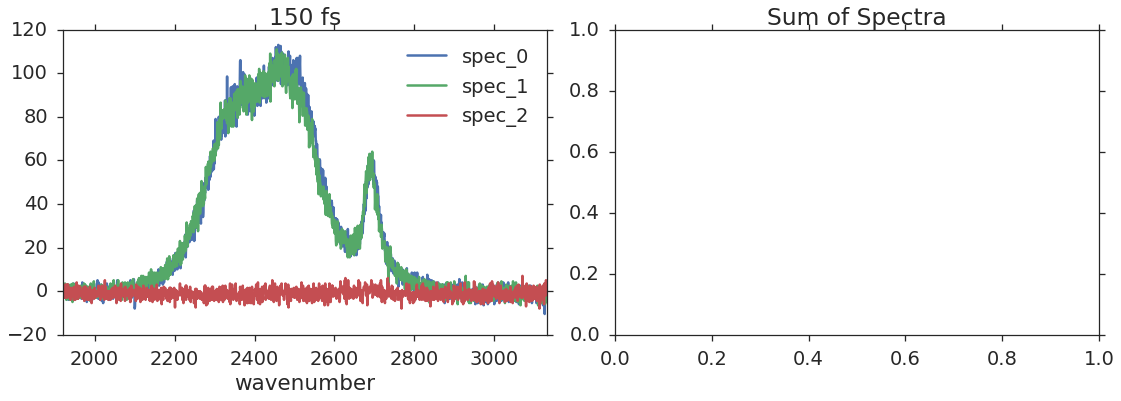

In [7]:
fig_pump_probe_get, axes_pump_probe_get = plt.subplots(1,2, figsize=(16,6))

ppWidget.ts0 = ipyw.interactive(set_pump_probe, fpath=ppWidget.ts0_fpath, sub_base=ppWidget.ts0_sub_base, normalize=ppWidget.ts0_normalize)
ppWidget.ts0_pumped.observe(ts0_pump_update, 'value')
ppWidget.ts0_probed.observe(ts0_probe_update, 'value')
pp


ppWidget.ts0_plot = ipyw.interactive(pump_probe_plot, pp_delay=ppWidget.ts0_ppdelay)
display(ppWidget.ts0, ppWidget.ts0_pumped, ppWidget.ts0_probed, ppWidget.ts0_plot)
pump_probe_sum_plot()

## Normalize Spectra

In [6]:
%%capture
fig_norm, ax_norm = plt.subplots(1,2, figsize=(12,6))
ax_norm[0].set_title("Unnormalized")
ax_norm[1].set_title("Normalized")
#ax_norm[1].set_ylim(-0.002, 0.015)
ppdData.ts0u.pumped.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[0], label="pumped")
ppdData.ts0u.probed.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[0], label="probed")

ppdData.ts0.pumped.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[1], label = "pumped")
ppdData.ts0.probed.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[1], label = "probed")

ax_norm[0].legend()
fig_norm.tight_layout()


def plot_norm_update(pp_delay):
    ax_norm[0].lines[0].set_ydata(ppdData.ts0u.pumped.ix[pp_delay])
    ax_norm[0].lines[1].set_ydata(ppdData.ts0u.probed.ix[pp_delay])

    ax_norm[1].lines[0].set_ydata(ppdData.ts0.pumped.ix[pp_delay])
    ax_norm[1].lines[1].set_ydata(ppdData.ts0.probed.ix[pp_delay])
       
    display(fig_norm)

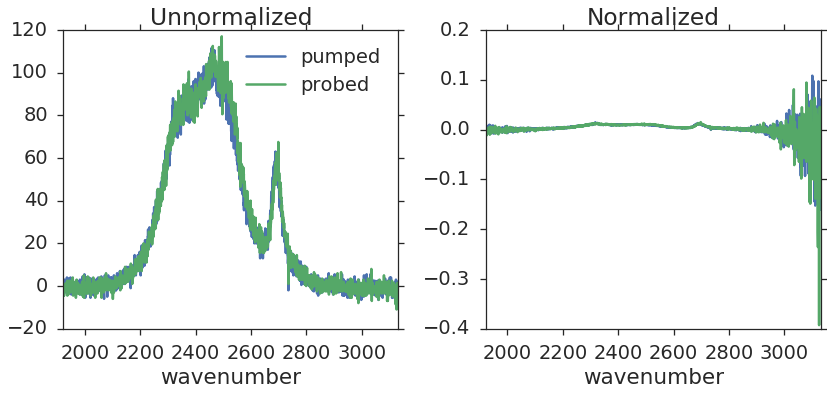

In [7]:
ipyw.interact(plot_norm_update, pp_delay=ppWidget.ts0_ppdelay_childs[0])

# Spectra Over Time

In [8]:
%%capture
roi = slice(2200,2800)

def plot_compare_update(pp_delay):
    for i in range(ppdData.ts0.df['spec_0'].shape[1]):
        data = ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_0"][roi].iloc[:,i]
        ax_compare[0].lines[i].set_ydata(data)
        data = ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_1"][roi].iloc[:,i]
        ax_compare[1].lines[i].set_ydata(data)
    
    display(fig_compare)
    

fig_compare, ax_compare = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_0"][roi].plot(ax=ax_compare[0])        
ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_1"][roi].plot(ax=ax_compare[1])
for ax, title in zip(ax_compare, ('spec_0', 'spec_1')):
    ax.set_title(title)
    for i in range(len(ax.lines)):
        ax.lines[i].set_label('run %i'%i)
    ax.legend()
#plt.ylim(-0.002, 0.017)

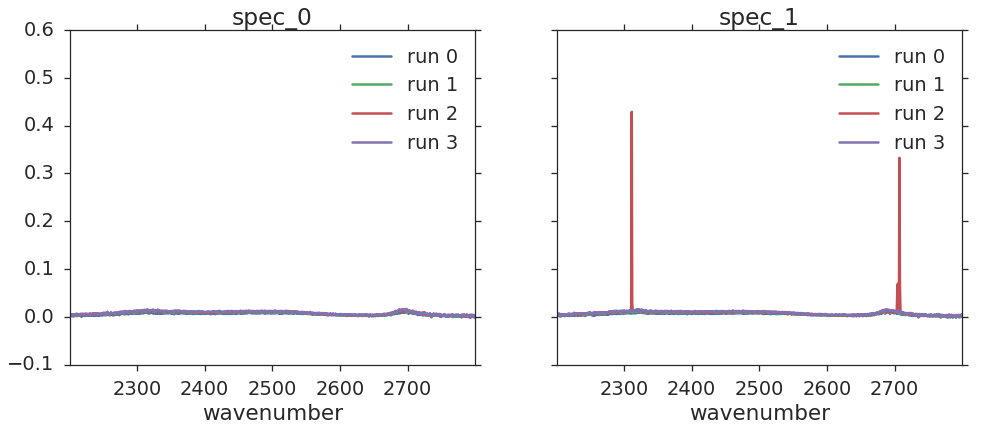

In [9]:
w_f0 = ipyw.interact(plot_compare_update, pp_delay=ppWidget.ts0_ppdelay_childs[1])
#display(w_f0)

## Smoothed

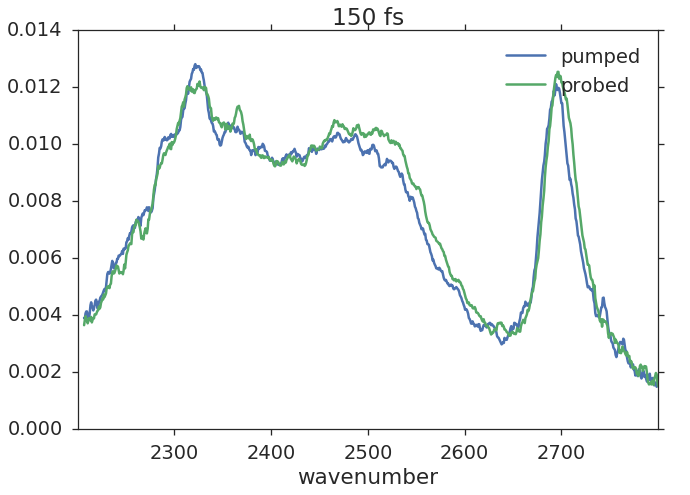

In [10]:
#pp_slider3 = ipyw.SelectionSlider(options=list(ppdData.ts0.pp_delays), value=0, continuous_update=False)
roi = slice(2200,2800) # get this from the pump
def p3(pp_delay):
    ppdData.ts0.pumped.loc[pp_delay][roi].rolling(10).mean().plot(label="pumped")
    ppdData.ts0.probed.loc[pp_delay][roi].rolling(10).mean().plot(label="probed")
    #plt.ylim(0.001, 0.015)
    plt.title(str(pp_delay) + " fs")
    plt.legend()
    #plt.grid()

ppWidget.p3 = ipyw.interactive(p3, pp_delay=ppWidget.ts0_ppdelay_childs[2])
display(ppWidget.p3)
plt.show()

# Bleach Trace

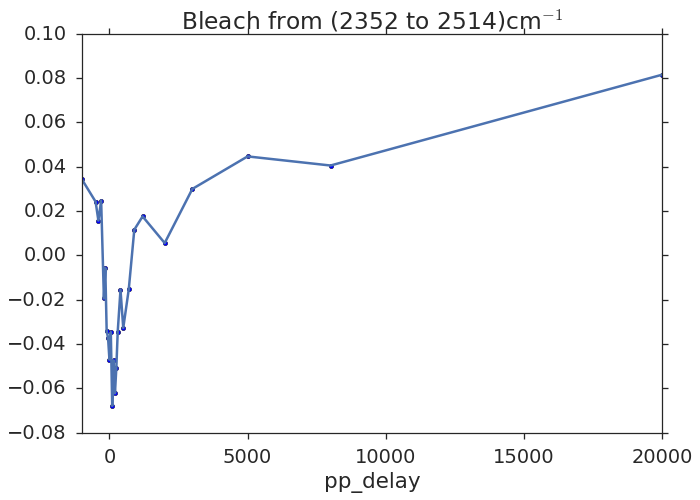

In [11]:
roi_slider_range = int(ppdData.ts0.df.index.levels[1].min()), int(ppdData.ts0.df.index.levels[1].max())
#roi_slider_range = 0, 800
roi_slider = ipyw.IntRangeSlider(
    value = (2450, 2600),
    min = roi_slider_range[0],
    max = roi_slider_range[1],
    continuous_update=False
)

#roi = slice(2450,2600)

def plot_bleach_trace(roi):
    tss = ppdData.ts0.bleach.unstack(0)
    tss = tss[(tss.index > roi[0]) & (tss.index < roi[1])].sum()

    tss.plot()
    plt.scatter(tss.index, tss)
    plt.title(r"Bleach from (%i to %i)cm$^{-1}$"%(roi[0], roi[1]))
    
ipyw.interact(plot_bleach_trace, roi=roi_slider)
plt.show()

In [16]:
ppdData.ts0.pump

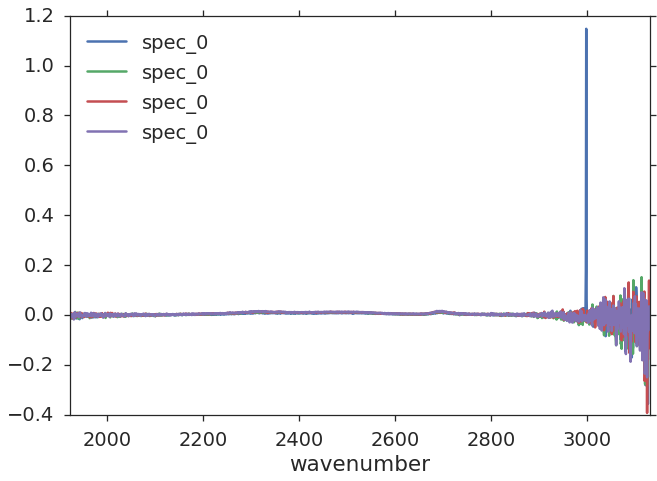

In [15]:
ppdData.ts0.df.ix[0, "spec_0"].plot()